In [1]:
# Import libs
import sys
sys.path
sys.path.append('../service/')

import random
import copy

import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import gempy as gp
from gempy.utils import section_utils

## TODO
- function to update withouth geo_model.init_data()
- avoide double computation of solution
- deactivate regular grid
- deactivate plotting
- split into function
- check workflow
- comments
- run on GPU

## Init geo_model
- Runs on init of app-process

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[2, 2, 2]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations      [3]


## Define functions

In [3]:
def update_series(geo_model, series_df):
    """Updates series of the geo-model to the one stored in data.
    
    Loops over series and appends missing ones and removes obsolet ones.
    
    Args:
        geo_model = The geo_model
        series_df: DataFrame = containing series data
    """

    # Get currently stored series data
    series_old = list(geo_model.series.df.to_dict()['order_series'].keys())

    # add new series
    for index, row in series_df.iterrows():

        serie_name = row['name']
        if serie_name not in series_old:

            geo_model.add_series(series_list=[serie_name])

    # remove obsolete series
    for serie in series_old:

        if serie not in series_df['name'].to_list():

            geo_model.delete_series(serie)

In [4]:
def update_faults_relations(geo_model, series_df):
    """Sets fault relations.
    
    Sets isfault property of surfaceses accordingly.
    
    Args:
        geo_model = The geo_model
        series_df: DataFrame = containing series data    
    """

    for index, row in series_df.iterrows():

        serie_name = row['name']
        serie_isfault = row['isfault']
        if serie_isfault:

            geo_model.set_is_fault([serie_name])

In [5]:
def update_surfaces(geo_model, surfaces_df):
    """Updates surfaces of the geo-model to the one stored in data.
    
    Adds missing surfaces and removes obsolet ones.

    Args:
        geo_model = The geo_model
        series_df: DataFrame = containing surface data
    """
    
    # Getting current surface data
    surfaces_old = geo_model.surfaces.df['surface'].to_list()

    # add and update surfaces
    for index, row in surfaces_df.iterrows():

        surface_name = row['name']
        surface_serie = row['serie']
        if surface_name not in surfaces_old:

            geo_model.add_surfaces(surface_list=[surface_name])
            gp.map_series_to_surfaces(
                geo_model,
                {surface_serie: surface_name}
            )

        else:

            gp.map_series_to_surfaces(
                geo_model,
                {surface_serie: surface_name}
            )

    # remove obsolete surfaces
    for surface in surfaces_old:

        if surface not in surfaces_df['name'].to_list():

            geo_model.delete_surfaces(surface)

In [6]:
def set_configuration_and_topology(
    geo_model,
    series_df,
    surfaces_df,
    extent,
    orientations_original_df,
    section_dict
):
    """Set topological and confiuration data of the geo_model based on
    input.
    
    Args:
    """
    
    # Topoligical Realtionships
    update_series(geo_model=geo_model, series_df=series_df)
    update_surfaces(geo_model=geo_model, surfaces_df=surfaces_df)
    
    # Set original geo-model
    # TODO: Replace with function
    
    gp.init_data(
        geo_model,
        extent=extent,
        resolution=[5, 5, 5],
        # orientations_df=orientations_original_df,
        update_surfaces=False
    )

    # Set fault realtions
    for index, row in series_df.iterrows():

        serie_name = row['name']
        serie_isfault = row['isfault']
        if serie_isfault:

            geo_model.set_is_fault([serie_name])

    # Set section grid  # Only one => client canvas
    geo_model.set_section_grid(section_dict=section_dict)
    geo_model.set_active_grid(grid_name=['sections'], reset=True)
    
    # update to interpolator
    geo_model.update_to_interpolator()

In [7]:
def manipulate_surface_points_inplace(surface_points_copy):
    """Manipulates the surface_points_copy dataframe.
    
        Samples X, Y, Z values form the original DataFrame and thier
        respective distribution types and parameters.\
        Potential update:
            - Sampling parameter per axis i.e. param1_x, param1_y, ...
            - Diffenrent sampling types i.e. normal, uniformal, ...
    
        Args:
            surface_points_copy: DataFrame = copy of the original geological
                input data surface-points DataFrame.
            surface_points_original_df: DataFrame = original geological input data
                surface-points DataFrame.
    """
    
    surface_points_copy['X'] = ss.norm.rvs(
        loc=surface_points_original_df['X'].values,
        scale=surface_points_original_df['param1'].values)
    surface_points_copy['Y'] = ss.norm.rvs(
        loc=surface_points_original_df['Y'].values,
        scale=surface_points_original_df['param1'].values)
    surface_points_copy['Z'] = ss.norm.rvs(
        loc=surface_points_original_df['Z'].values,
        scale=surface_points_original_df['param1'].values)    

In [8]:
def run_realizations(
    geo_model,
    n_realizations,
    surface_points_original_df,
    series_df,
    orientations_original_df,
    section_dict
):
    """Runs x ralizations, interpolates sections and returns them as 
    a list.
    
    If gp.compute_model(model=geo_model) fails, the last known interpolation
    gets run.
    """

    # Copy geological input data to manipulate per realization.
    surface_points_copy = copy.deepcopy(surface_points_original_df)

    # Storage for calucalted ralizations
    list_section_data = []

    # TODO: Move Topological Realtaions updates to here

    # Calculate realizations
    for i in range(n_realizations):

        print(f'Realization: {i}')
        
        # manipulate surface_points_copy in place
        manipulate_surface_points_inplace(surface_points_copy)
        
        # Set manipulated surface points
        geo_model.set_surface_points(surface_points_copy, update_surfaces=False)
        geo_model.set_orientations(orientations_original_df, update_surfaces=False)

        # update to interpolator
        geo_model.update_to_interpolator()

        # Compute solution
        # TODO: Fix bug!
        # till here: until 90.1 ms for 1 realizations
        # 213 m with 2x gp.compute_model()
        try:
            solution = gp.compute_model(model=geo_model)
            solution = gp.compute_model(model=geo_model)
            # gp.plot.plot_section_by_name(geo_model, 'section')
        except ValueError as err:
            print('ValueError')
            # Append last working realization
            list_section_data.append(geo_model
                                     .solutions
                                     .sections[0][0]
                                     .reshape(section_dict['section'][2])
                                     )

            
        # collect extracted section data
        list_section_data.append(geo_model
                                 .solutions
                                 .sections[0][0]
                                 .reshape(section_dict['section'][2])
                                 )

    return list_section_data

In [9]:
def process_list_section_data(list_section_data):

    # Process results Stack results
    section_data_stack = np.round(np.dstack(list_section_data))

    # Get lithologies in stack
    lithology_ids = np.unique(section_data_stack)

    return section_data_stack, lithology_ids

In [10]:
def count_lithology_occurrences_over_realizations(
        section_data_stack,
        lithology_ids,
        section_dict
):

    count_array = np.empty((
        section_dict['section'][2][0],
        section_dict['section'][2][1],
        len(lithology_ids)))

    for index, lithology in enumerate(lithology_ids):

        count_array[:, :, index] = np.sum((
            section_data_stack == lithology).astype(int), axis=2)

    return count_array

In [11]:
def calculate_information_entropy(count_array, n_realizations):

    # Calculate information entropy
    probability_array = count_array / n_realizations
    return ss.entropy(probability_array, axis=2)

#### Import topological data and set topological realtionships

In [12]:
# Import topological data
series_df = pd.read_csv('./data/simple_fault_model_series.csv')
surfaces_df = pd.read_csv('./data/simple_fault_model_surfaces.csv')

#### Import and format geological imput data

In [13]:
# Import geological imput data
surface_points_input_data = pd.read_csv('./data/simple_fault_model_points.csv')
orientaions_input_data = pd.read_csv('./data/simple_fault_model_orientations.csv')

In [14]:
# Format geological_input_data
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df['param1'] = 10

# Orientaions
orientations_original_df = orientaions_input_data[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

#### Section grid


In [15]:
section_dict = {'section': ([0, 0], [0, 2000], [200,200])}

#### UQ

In [16]:
# Constants
n_realizations = 2

# Setup original model
set_configuration_and_topology(
    geo_model=geo_model,
    series_df=series_df,
    surfaces_df=surfaces_df,
    extent=[0,2000,0,2000,0,2000],
    orientations_original_df=orientations_original_df,
    section_dict=section_dict
)

# Run realizations
list_section_data = run_realizations(
    geo_model=geo_model,
    n_realizations=n_realizations,
    surface_points_original_df=surface_points_original_df,
    series_df=series_df,
    orientations_original_df=orientations_original_df,
    section_dict=section_dict
)

# Process output
section_data_stack, lithology_ids = process_list_section_data(
    list_section_data=list_section_data)

# Count occurrences
count_array = count_lithology_occurrences_over_realizations(
        section_data_stack=section_data_stack,
        lithology_ids=lithology_ids,
        section_dict=section_dict
)

# Calculate entrop
entropy_map = calculate_information_entropy(
    count_array=count_array, n_realizations=n_realizations)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
Active grids: ['sections']
Realization: 0
Realization: 1


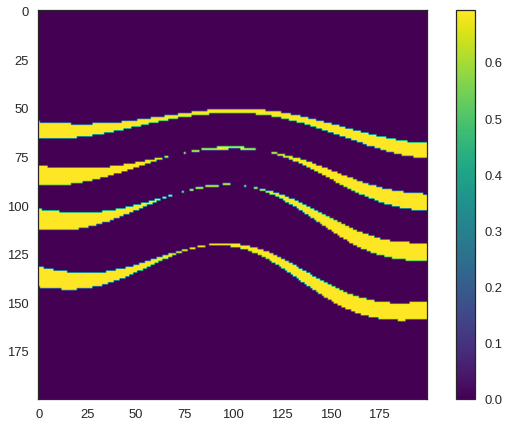

In [17]:
plt.imshow(entropy_map[:,::-1].T, cmap='viridis')
plt.colorbar()
plt.show()

#### Questions
- ValueError: Surface level must be within volume data range.
- conditions for .compute_model()
- 1x Orientation per Sereis and 2x SurfacePoints per Surface
- f_geologcial_input_data() => modify_surface_points